# Data science blog post - Notebook
By AYDI Abdelkarim, PhD

# Setup

In [1]:
# Data wrangling
import pandas as pd

# Data Viz
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning 
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Introduction

In this blogbpost, I will be analyzing the latest StackOverFlow survey 2019 data set to answer the following questions:

- What are the current tech trends (2019) in terms of programming languages, data base systems, web development frameworks ?
- What are the next tech trends (2020) in terms of programming languages, data base systems, web development frameworks ?
- What determines the most the satisfaction of a professional programmer ?


__Methodology__

In this blog post, I follow the CRISP-DM process for developping data driven projects. Check this link for further information [here](https://fr.wikipedia.org/wiki/Cross_Industry_Standard_Process_for_Data_Mining)

## Business context

I used the data set from Insight web site: [data source](https://insights.stackoverflow.com/survey). The data set is the full, cleaned results of the 2019 Stack Overflow Developer Survey. The data set is anonymized to protect the privacy of respondents. The survey was fielded from January 23 to February 14, 2019. The median time spent on the survey for qualified responses was 23.3 minutes. This analysis can be useful to track tech world trends and prepare for coming evolutions.

# Gather data

I downloaded the most recent Stackoverflow survey result from [here](https://insights.stackoverflow.com/survey), unzipped the file in `./data/raw`.

In [2]:
schema = pd.read_csv("./data/raw/survey_results_schema.csv")
survey = pd.read_csv("./data/raw/survey_results_public.csv")

# Assess data

In [3]:
schema.head()

,Column,QuestionText
0,Respondent,Randomized respondent ID number (not in order ...
1,MainBranch,Which of the following options best describes ...
2,Hobbyist,Do you code as a hobby?
3,OpenSourcer,How often do you contribute to open source?
4,OpenSource,How do you feel about the quality of open sour...


In [4]:
survey.head()

,Respondent,MainBranch,Hobbyist,OpenSourcer,OpenSource,Employment,Country,Student,EdLevel,UndergradMajor,...,WelcomeChange,SONewContent,Age,Gender,Trans,Sexuality,Ethnicity,Dependents,SurveyLength,SurveyEase
0,1,I am a student who is learning to code,Yes,Never,The quality of OSS and closed source software ...,"Not employed, and not looking for work",United Kingdom,No,Primary/elementary school,NaN,...,Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,14.0,Man,No,Straight / Heterosexual,NaN,No,Appropriate in length,Neither easy nor difficult
1,2,I am a student who is learning to code,No,Less than once per year,The quality of OSS and closed source software ...,"Not employed, but looking for work",Bosnia and Herzegovina,"Yes, full-time","Secondary school (e.g. American high school, G...",NaN,...,Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,19.0,Man,No,Straight / Heterosexual,NaN,No,Appropriate in length,Neither easy nor difficult
2,3,"I am not primarily a developer, but I write co...",Yes,Never,The quality of OSS and closed source software ...,Employed full-time,Thailand,No,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Web development or web design,...,Just as welcome now as I felt last year,Tech meetups or events in your area;Courses on...,28.0,Man,No,Straight / Heterosexual,NaN,Yes,Appropriate in length,Neither easy nor difficult
3,4,I am a developer by profession,No,Never,The quality of OSS and closed source software ...,Employed full-time,United States,No,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",...,Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,22.0,Man,No,Straight / Heterosexual,White or of European descent,No,Appropriate in length,Easy
4,5,I am a developer by profession,Yes,Once a month or more often,"OSS is, on average, of HIGHER quality than pro...",Employed full-time,Ukraine,No,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",...,Just as welcome now as I felt last year,Tech meetups or events in your area;Courses on...,30.0,Man,No,Straight / Heterosexual,White or of European descent;Multiracial,No,Appropriate in length,Easy


In [5]:
n,p = survey.shape
print(f"The data set contains {n} rows and {p} columns")

The data set contains 88883 rows and 85 columns


After inspecting the survey schema to extract the most relevant features, I selected the following feature for my anamysis.

In [6]:
features = ["Employment",
            "Country",
            "JobSat",
            "ConvertedComp",
            "WorkWeekHrs",
            "WorkChallenge",
            "LanguageWorkedWith",
            "LanguageDesireNextYear",
            "DatabaseWorkedWith",
            "DatabaseDesireNextYear",
            "WebFrameWorkedWith",
            "WebFrameDesireNextYear",
            "Age",
            "Gender"]

select_schema = (schema.
                 set_index("Column").
                 reindex(features)
                )

select_survey = survey[features]

select_schema

,QuestionText
Column,
Employment,Which of the following best describes your cur...
Country,In which country do you currently reside?
JobSat,How satisfied are you with your current job? (...
ConvertedComp,Salary converted to annual USD salaries using ...
WorkWeekHrs,"On average, how many hours per week do you work?"
WorkChallenge,"Of these options, what are your greatest chall..."
LanguageWorkedWith,"Which of the following programming, scripting,..."
LanguageDesireNextYear,"Which of the following programming, scripting,..."
DatabaseWorkedWith,Which of the following database environments h...


# Clean data

## Keeping only professional programmers

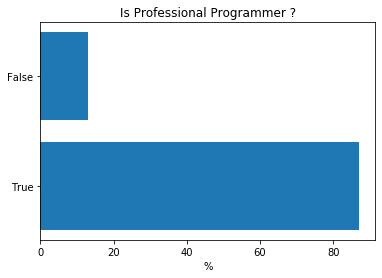

In [7]:
# Professional programmer categories
employment_categories = ['Employed part-time',
                         'Independent contractor, freelancer, or self-employed',
                         'Employed full-time']

# Adding a flag
select_survey["IsProfessional"] = [ x in employment_categories for x in select_survey["Employment"]]

# Plotting flag distribtion in the original data set
data = 100*select_survey["IsProfessional"].value_counts(normalize=True)
plt.barh(["True","False"],data.values)
plt.title(f"Is Professional Programmer ?")
plt.xlabel("%")
plt.savefig(f"./figures/Original data set is_professional_programmer.png")
plt.show()

# Keepiing only professional programmers
df = select_survey[select_survey.IsProfessional].copy()

## Assessing missing values

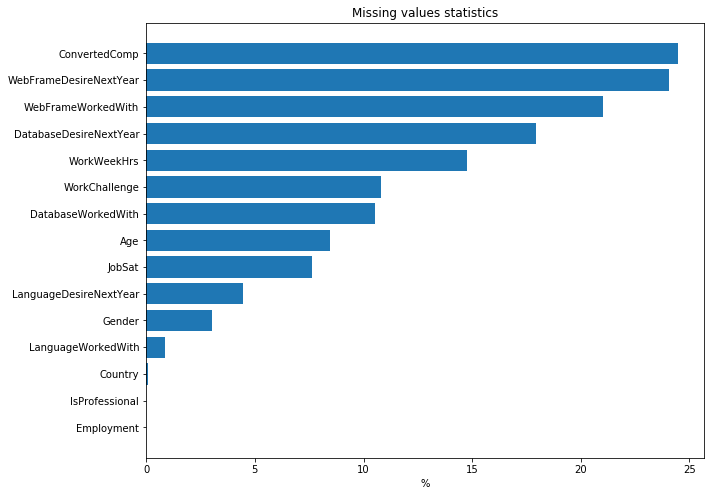

In [8]:
plt.figure(figsize=(10,8))
na_stats = 100/n*df.isna().sum(axis=0).sort_values(ascending=True)
plt.barh(na_stats.index,na_stats.values)
plt.title("Missing values statistics")
plt.xlabel("%")
plt.savefig(f"./figures/na_stats.png")
plt.show()

__Comment__:

This data set contains quite a lot of missing values that need to be properly handled, especially features related to Job satisfaction modeling like total compensation. 

# Analyze data

## Analyzing profiles

Before delving in answering questions, let's have a broad overview of respondants profiles.

### Age

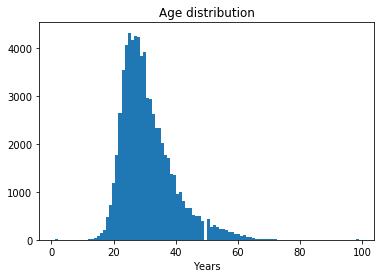

In [9]:
feature = "Age"
data = df[feature].dropna()
plt.hist(data.values,bins=100)
plt.title(f"{feature} distribution")
plt.xlabel("Years")
plt.savefig(f"./figures/{feature}")
plt.show()

### Country

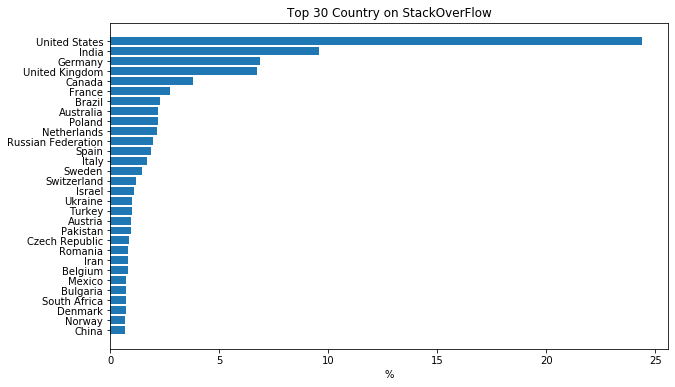

In [10]:
feature = "Country"
data = 100*df[feature].value_counts(normalize=True,ascending=True)[-30:]
plt.figure(figsize=(10,6))
plt.barh(data.index,data.values)
plt.title(f"Top 30 {feature} on StackOverFlow")
plt.xlabel("%")
plt.savefig(f"./figures/{feature}")
plt.show()

### Gender

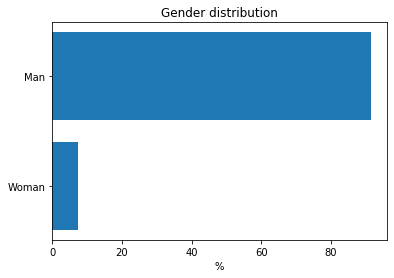

In [11]:
feature = "Gender"
data = 100*df[feature].value_counts(normalize=True).reindex(["Woman", "Man"])
plt.figure(figsize=(6,4))
plt.barh(data.index,data.values)
plt.title(f"{feature} distribution")
plt.xlabel("%")
plt.savefig(f"./figures/{feature}")
plt.show()

### Employment situation

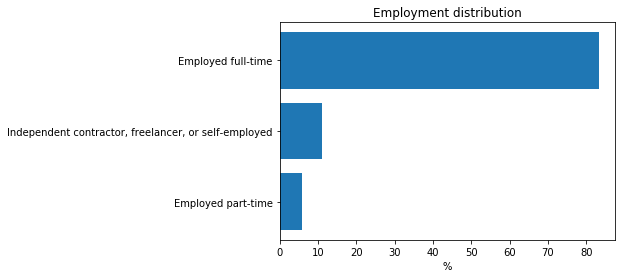

In [12]:
feature = "Employment"
data = 100*df[feature].value_counts(normalize=True,ascending=True)
plt.figure(figsize=(6,4))
plt.barh(data.index,data.values)
plt.title(f"{feature} distribution")
plt.xlabel("%")
plt.savefig(f"./figures/{feature}")
plt.show()

### Job satisfaction

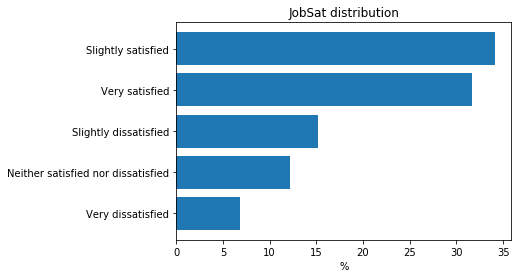

In [13]:
feature = "JobSat"
data = 100*df[feature].value_counts(normalize=True,ascending=True)
plt.figure(figsize=(6,4))
plt.barh(data.index,data.values)
plt.title(f"{feature} distribution")
plt.xlabel("%")
plt.savefig(f"./figures/{feature}")
plt.show()

### Total Compensation

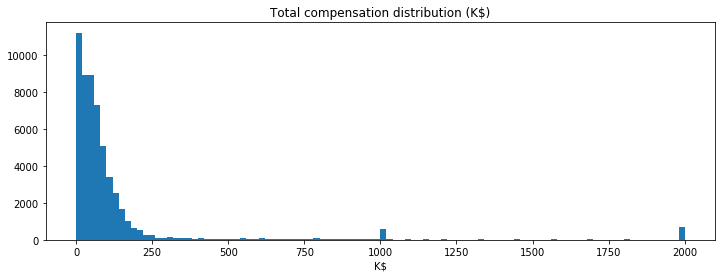

In [14]:
feature = "ConvertedComp"
data = df[feature].dropna()*0.001
plt.figure(figsize=(12,4))
plt.hist(data.values,bins=100)
plt.title(f"Total compensation distribution (K$)")
plt.xlabel("K$")
plt.savefig(f"./figures/{feature}")
plt.show()

In [15]:
data = df[feature].dropna()*0.001
data.mean(), data.median()

(127.23674041483345, 57.287)

__Comments__

These charts show some intersting insights about the respondants population:

- Almost 25% of respondants are from United States, folllowed by India 10%. It is surprising that Chineese developpers, which are strong Tech Actors are not using the SOF. The data set is biaised towards these countries and conclusions should not be generalized quickly.

- Respondants are in huge majority males with a mean age of 32 years but the age distribution is skwed to the right.

- Respondants are in majority satsified with their jobs in 65% of cases

- Total conpensation are very skwed to the right with some outiliers earning up to 3M$/year of compensation !!! Median compensation is 57K$ and mean is 127 K$



# Answering questions

## Question 1
- __What are the current tech trends (2019) in terms of programming languages, data base systems,  web development frameworks ?__

In [16]:
tech_features = ["LanguageWorkedWith",
                "LanguageDesireNextYear",
                "DatabaseWorkedWith",
                "DatabaseDesireNextYear",
                "WebFrameWorkedWith",
                "WebFrameDesireNextYear"]
df[tech_features].head()

,LanguageWorkedWith,LanguageDesireNextYear,DatabaseWorkedWith,DatabaseDesireNextYear,WebFrameWorkedWith,WebFrameDesireNextYear
2,HTML/CSS,Elixir;HTML/CSS,PostgreSQL,PostgreSQL,NaN,Other(s):
3,C;C++;C#;Python;SQL,C;C#;JavaScript;SQL,MySQL;SQLite,MySQL;SQLite,NaN,NaN
4,C++;HTML/CSS;Java;JavaScript;Python;SQL;VBA,HTML/CSS;Java;JavaScript;SQL;WebAssembly,Couchbase;MongoDB;MySQL;Oracle;PostgreSQL;SQLite,Couchbase;Firebase;MongoDB;MySQL;Oracle;Postgr...,Django;Express;Flask;jQuery;React.js;Spring,Flask;jQuery;React.js;Spring
5,Java;R;SQL,Python;Scala;SQL,MongoDB;PostgreSQL,PostgreSQL,NaN,NaN
6,HTML/CSS;JavaScript,HTML/CSS;JavaScript,NaN,NaN,React.js,React.js


In [17]:
def unpivot(df,feature, new_feature):
    """
    Unpivot a df based on column named feature as pivot
    
    Args:
    df: pd.DataFrame
    feature: str
    new_feature: str
    
    Returns:
    unpivoted_df: pd.DataFrame
    """

    unpivoted_df = (df[feature]
           .str
           .split(";",expand=True)
           .reset_index()
           .rename(columns={"index":"respondant_id"})
           .melt(id_vars="respondant_id",value_name=new_feature)
           .drop("variable",axis=1)
           .dropna(axis=0)
          )
    return unpivoted_df

In [18]:
agg_data = {}
agg_data["Language"] = unpivot(df,"LanguageWorkedWith","Language")
agg_data["Database"] = unpivot(df,"DatabaseWorkedWith","Database")
agg_data["WebFrame"] = unpivot(df,"WebFrameWorkedWith","WebFrame")

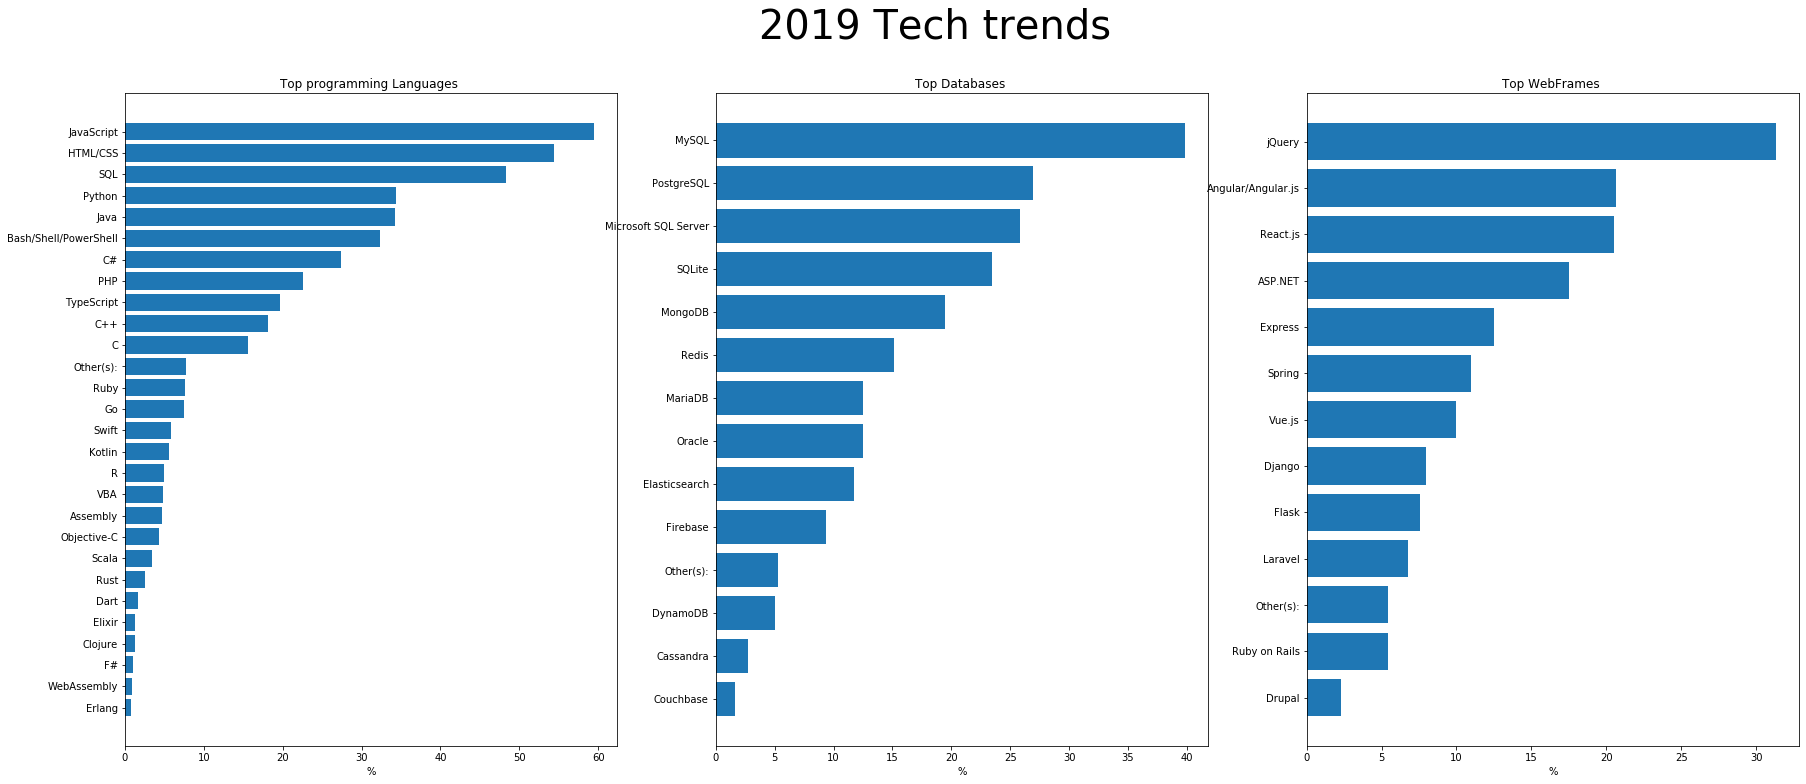

In [19]:
# Visualize current Tech trends
fig, axes = plt.subplots(1,3,figsize=(30,12))

feature = "Language"
data =  100/n*agg_data[feature][feature].value_counts(ascending=True)
axes[0].barh(data.index,data.values)
axes[0].set_title(f"Top programming {feature}s ")
axes[0].set_xlabel("%")

feature = "Database"
data =  100/n*agg_data[feature][feature].value_counts(ascending=True)
axes[1].barh(data.index,data.values)
axes[1].set_title(f"Top {feature}s ")
axes[1].set_xlabel("%")

feature = "WebFrame"
data =  100/n*agg_data[feature][feature].value_counts(ascending=True)
axes[2].barh(data.index,data.values)
axes[2].set_title(f"Top {feature}s ")
axes[2].set_xlabel("%")

fig.suptitle("2019 Tech trends",fontsize=40);
fig.savefig(f"./figures/current_tech_trends",bbox_inches="tight")

__Comment__


The charts summarizes current popular technologies. The TOP 5 technologies in each categories are:
- programming languages: JavaScript (59.4%), HTML/CSS (54.4%), SQL (48.2%), Python (34.4%) and Java (34.2%)
- database systems: MySQL (39.8%), PostgreSQL (26.9%), Microsoft SQL Server (25.7%), SQLite (23.4%), MongoDB (19.4%)
- Webframe technologies: jQuery (31.2%), Angular/Angular.js (20.6%), React.js (20.5%), ASP.NET (17.4%), Express (12.5%)

The general trend is related with web development technologies (back and front) and mainly relational databases.

## Question 2
- __What are the next tech trends (2020) in terms of programming languages, data base systems, platforms, web development frameworks ?__


In [20]:
agg_data = {}
agg_data["LanguageNext"] = unpivot(df,"LanguageDesireNextYear","LanguageNext")
agg_data["DatabaseNext"] = unpivot(df,"DatabaseDesireNextYear","DatabaseNext")
agg_data["WebFrameNext"] = unpivot(df,"WebFrameDesireNextYear","WebFrameNext")

Drupal                 1.393967
Other(s):              5.123589
Ruby on Rails          6.324044
Laravel                6.336420
Flask                  7.770890
Spring                10.037915
Django                10.350686
Express               11.898788
ASP.NET               13.623528
jQuery                16.132444
Angular/Angular.js    19.560546
Vue.js                20.046578
React.js              29.715469
Name: WebFrameNext, dtype: float64


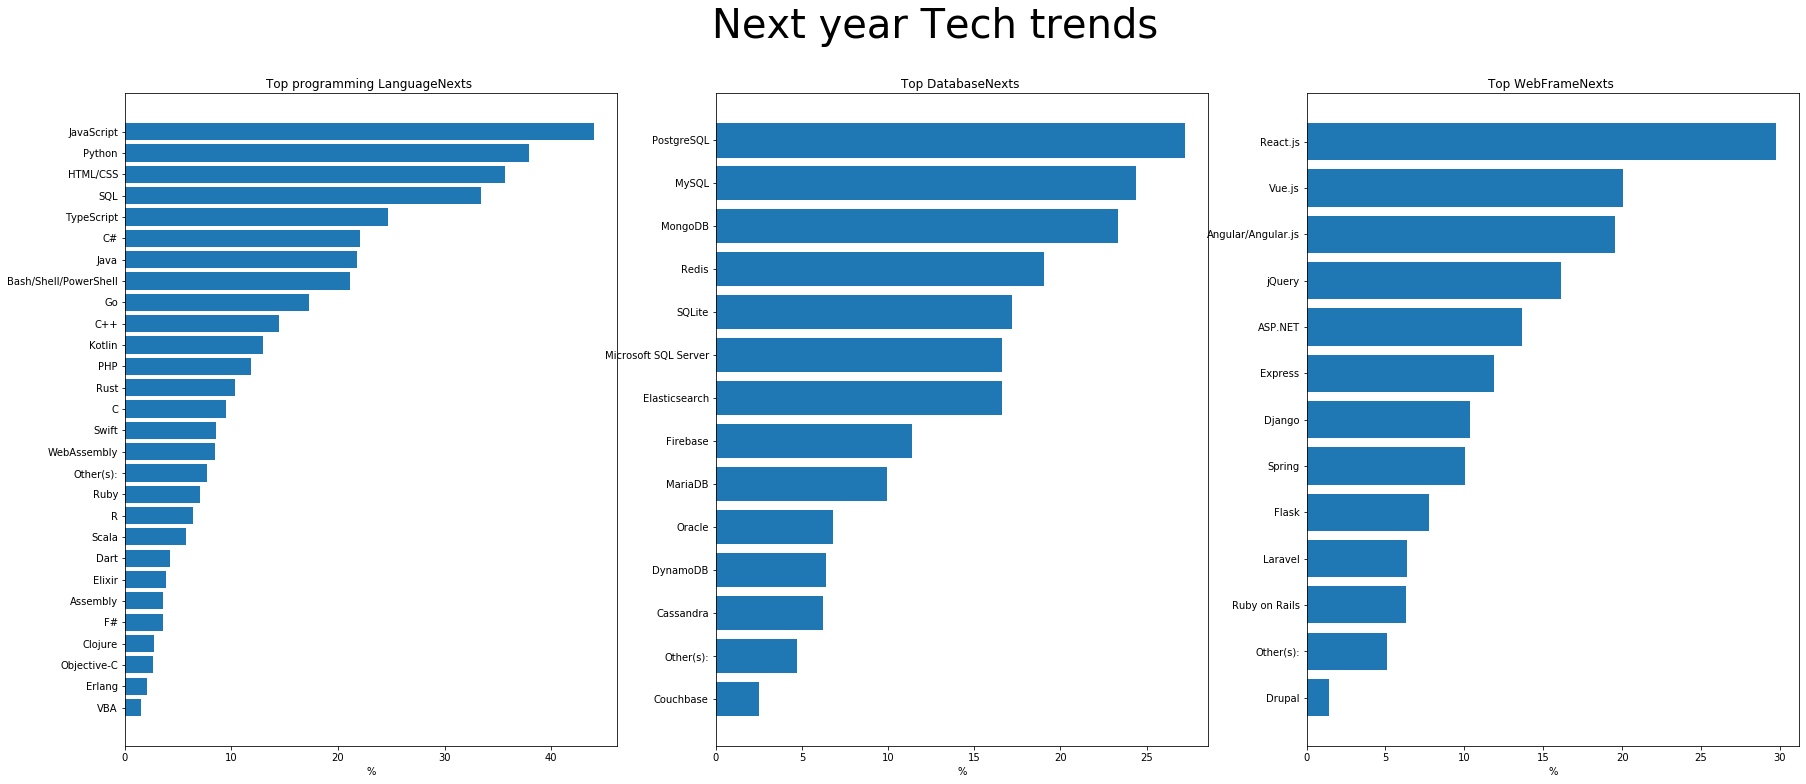

In [21]:
fig, axes = plt.subplots(1,3,figsize=(30,12))

feature = "LanguageNext"
data =  100/n*agg_data[feature][feature].value_counts(ascending=True)
axes[0].barh(data.index,data.values)
axes[0].set_title(f"Top programming {feature}s ")
axes[0].set_xlabel("%")

feature = "DatabaseNext"
data =  100/n*agg_data[feature][feature].value_counts(ascending=True)
axes[1].barh(data.index,data.values)
axes[1].set_title(f"Top {feature}s ")
axes[1].set_xlabel("%")

feature = "WebFrameNext"
data =  100/n*agg_data[feature][feature].value_counts(ascending=True)
print(data)
axes[2].barh(data.index,data.values)
axes[2].set_title(f"Top {feature}s ")
axes[2].set_xlabel("%")

fig.suptitle("Next year Tech trends",fontsize=40);
fig.savefig(f"./figures/next_tech_trends",bbox_inches="tight")

The charts summarizes next year popular technologies. The TOP 5 technologies in each categories are:

- programming languages: JavaScript (44.0%), Python (37.9%), HTML/CSS (35.7%), SQL (33.4%), TypeScript (24.6%)
- database systems: PostgreSQL (27.2%), MySQL (24.3%), MongoDB (23.3%), Redis (19.0%), SQLite (17.1%)
- Webframe technologies: React.js (29.7%), Vue.js (20.0%), Angular/Angular.js (19.5%), jQuery (16.1%), ASP.NET (13.6%)

The dominance of JavaScript will be less important as Python will become extremely popular and a desired language to learn and work with. Another rising programming language will be TypeScript, a language to improve and secure production level JavaScript, opensourced by Microsoft. As for database systems, MySQL is llosing its leader position in favor of PostgreSQL. Finally, regarding web frameworks, React.Js is taking the lead from jQuery.

## Question 3
- __Which are most accurate predictors of job jatisfaction of a professional programmer ?__

First, I started by selecting the top 3 most informative features from the original data set.

- `ConvertedComp`
- `WorkWeekHrs`
- `WorkChallenge`

To determine these features influence on job satisfaction, I will train an ML algorithm (in this case, a Random Forrest classifier (RFC)) to predict job satisfaction and then extract feature importance ( like coefficient magnitude or information gain from a RFC.
To do so, I needed to prepare this new data set by performaing some data wrangling and cleaning summarized in these steps:
- Delete missing values
- Split WorkChallenge features across columns and fill missing values with 0
- Merge the obtainned data frames

I compacted all these steps in a function `prepare_data`

In [22]:
def prepare_data(df_survey):
    """
    Prepare data for applying ML algorithm to predict job satisfaction
    
    Args:
    - df_survey: pd.DataFrame   Raw survey data
    
    Returns:
    - df: pd.DataFrame   Tabular data ready for ML
    """

    # Step 0: Select features
    
    features = ["ConvertedComp",
                "WorkWeekHrs",
                "WorkChallenge",
                "JobSat"]

    df_survey = df_survey[features].copy()
    
    # Step 1
    print(f'# of rows before dropping missing values:{df_survey.shape[0]}')
    df_ = df_survey.dropna(subset=features)
    print(f'# of rows after dropping missing values:{df_.shape[0]}')

    # Step 2
    df_challenge = df_[["WorkChallenge"]].copy()
    df_challenge = unpivot(df_challenge,"WorkChallenge","challenge")
    df_challenge["value"] = 1
    df_challenge = pd.pivot(df_challenge,
                            index="respondant_id",
                            columns="challenge",
                            values="value")
    df_challenge = df_challenge.fillna(0)
    df_challenge.columns.name = ""
    df_challenge.index.name = ""
    
    # Step 3
    df_ = df_.drop("WorkChallenge",axis=1)
    df = pd.merge(left=df_,right=df_challenge,how="left",right_index=True,left_index=True)

    print(f'# of rows after completing steps:{df.shape[0]}')
    
    return df

In [23]:
# Let's check the result
df_q3 = prepare_data(df)
df_q3.head()

# of rows before dropping missing values:77420
# of rows after dropping missing values:53648
# of rows after completing steps:53648


,ConvertedComp,WorkWeekHrs,JobSat,Being tasked with non-development work,Distracting work environment,Inadequate access to necessary tools,Lack of support from management,Meetings,"Non-work commitments (parenting, school work, hobbies, etc.)",Not enough people for the workload,Time spent commuting,Toxic work environment
2,8820.0,40.0,Slightly satisfied,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
8,95179.0,32.0,Slightly satisfied,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
12,90000.0,40.0,Very satisfied,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
13,57060.0,40.0,Very satisfied,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
15,455352.0,40.0,Slightly satisfied,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### Visualize data

Before feeding this data to the algorithm, I will visulize the correlation matrix as a heat map to detect visual insights. To do so, I convert the `JobSat` categorical feature to a numeric one given the following order.


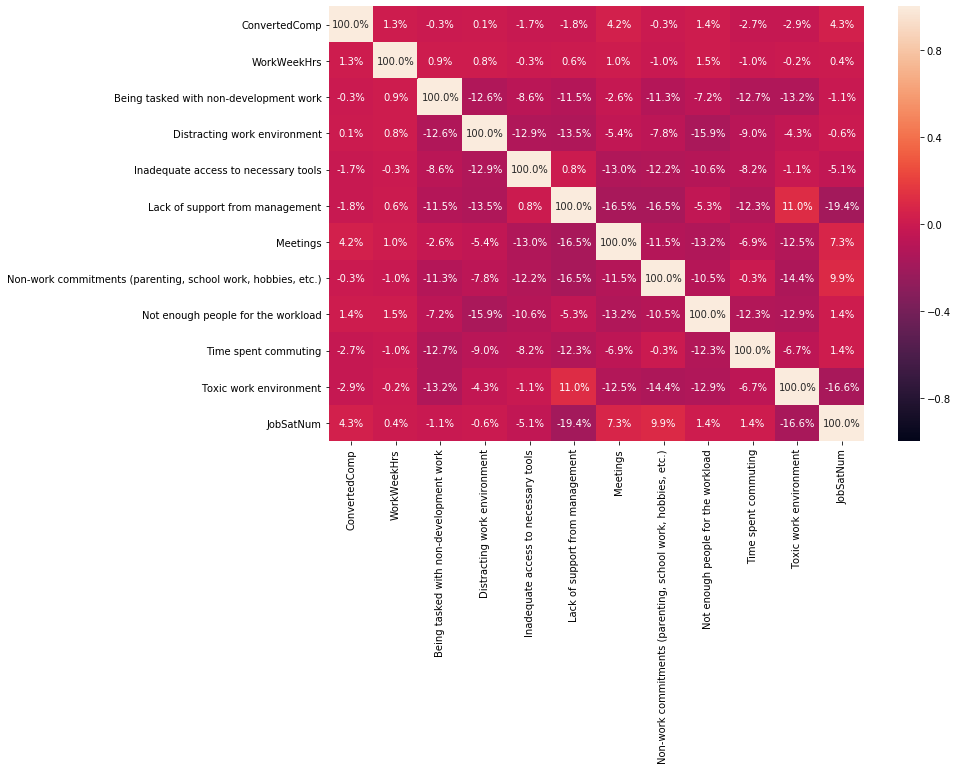

In [24]:
order = [['Very dissatisfied',
         'Slightly dissatisfied',
         'Neither satisfied nor dissatisfied',
         'Slightly satisfied',
         'Very satisfied']]

encoder = OrdinalEncoder(order)
df_q3["JobSatNum"] = encoder.fit_transform(df_q3[["JobSat"]])
data = df_q3.copy()
M = data.drop("JobSat",axis=1).corr()
plt.figure(figsize=(12,8))
sns.heatmap(M,vmin=-1,vmax=1,annot=True,fmt='.1%')
plt.savefig(f"./figures/correlation_matrix.png",bbox_inches="tight")
plt.show()

In [25]:
M.loc["JobSatNum"].sort_values().reset_index().rename(columns={"index":"Factor"})

,Factor,JobSatNum
0,Lack of support from management,-0.194437
1,Toxic work environment,-0.166380
2,Inadequate access to necessary tools,-0.051341
3,Being tasked with non-development work,-0.011434
4,Distracting work environment,-0.006165
5,WorkWeekHrs,0.003869
6,Not enough people for the workload,0.013809
7,Time spent commuting,0.014471
8,ConvertedComp,0.043115
9,Meetings,0.072990


__Comment__:

This heatmap is very insightful. In fact, the most single correlated in absolute is lack of support from management, then toxic workplace. One surprising insight is that compensation is not the most criterion to consider in job satisfaction. 

### Model data

In [26]:
y = df_q3["JobSat"]
X = df_q3.drop(["JobSat","JobSatNum"],axis=1)
X_tr, X_test, y_tr , y_test = train_test_split(X,y,test_size=0.2)
rfc = RandomForestClassifier(n_estimators=100)

#### Training

In [27]:
cv_scores = cross_val_score(rfc, X_tr, y_tr, cv=5, n_jobs=-1,scoring="accuracy")
print('Model accuracy mean: {:2.1%}'.format(cv_scores.mean()))
print('Model accuracy std: {:2.1%}'.format(cv_scores.std()))
rfc = RandomForestClassifier(n_estimators=500, max_depth=5)
rfc.fit(X_tr,y_tr)
y_pred = rfc.predict(X_tr)
tr_score = accuracy_score(y_pred, y_tr)
print('Model training accuracy: {:2.1%}'.format(tr_score))
y_pred = rfc.predict(X_test)
test_score = accuracy_score(y_pred, y_test)
print('Model test accuracy: {:2.1%}'.format(test_score))

Model accuracy mean: 30.1%
Model accuracy std: 0.3%
Model training accuracy: 39.3%
Model test accuracy: 39.0%


#### Features importance

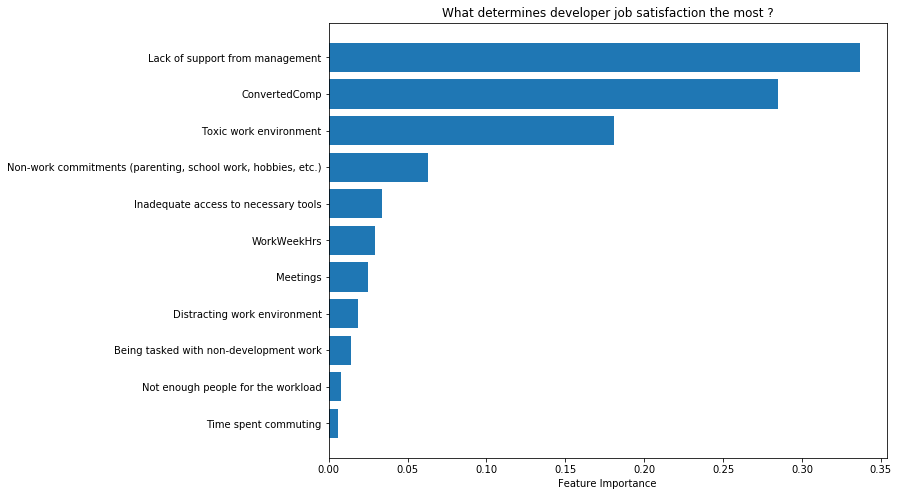

In [28]:
feature_imp = pd.DataFrame({"importance":[]}, index=[] )
for feature, imp in zip(X_tr.columns, rfc.feature_importances_):
    feature_imp.loc[feature,"importance"] = imp

    
plt.figure(figsize=(10,8))
data = feature_imp.importance.sort_values(ascending=True)
plt.barh(data.index,data.values)
plt.title("What determines developer job satisfaction the most ?")
plt.xlabel("Feature Importance")
plt.savefig(f"./figures/rfc_feature_importance.png",bbox_inches="tight")
plt.show()

__Comment__:

Feature importance computed using RFC are coherent with linear correlations inspected earlier. In fact, once again the most critical factor for assessing job satisfaction is __the support the professional feels from management__ followed by __total compensation__.

However, the model accuracy is low because using out of the box algorithm. Hence, its results are to be taken with precaution. A next step, is to invest in imporving the model performance to extract robust conclusions.



# Conclusion

In this post, I tried to follow a principled approach (CRISP-DM) to carry the analysis of StackOverFlow annual survey data. I hope you learned more about current tech trends and next year evolutions to prepare yourself for the best. Outised a technical scope, a professional developper is also highly impacted by human factors (management support or good work place culture) even more than financial consideration in some cases. I hope these insights help you decide for your next professional move.

The analyzed data set is way more insightful and my analysis only examined a few aspects and hardly scratch the surface of the other insights/trends can be drawn from it. This work can serve as starting point for more throrough analysis.